In [ ]:
import os
import csv
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.metrics import Precision, Recall
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive")

dir = "./drive/My Drive/ML/Hw3/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocess

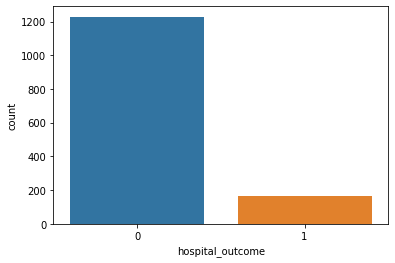

In [ ]:
df = pd.read_csv(dir + "cxr_label_train.csv")
patient_id = df['PATIENT ID'].tolist()
label = np.array(df['hospital_outcome']).reshape(-1, 1)
sns.countplot(df['hospital_outcome'], label="Sum")

In [ ]:
data = []
for id in tqdm(patient_id):
  filepath = dir + "IML_CXR_TRAIN/" + str(id) + ".jpg"
  if os.path.exists(filepath):
    img = image.load_img(filepath, grayscale=True, target_size=(64, 64))
    img = np.array(img)
    data.append(img)
data = np.array(data).reshape(-1, 64, 64, 1)

# normalization
data = data / 255.0

100%|██████████| 1392/1392 [04:28<00:00,  5.18it/s]


In [ ]:
def getNumericData(filepath, patient_id):
  df = pd.read_csv(filepath)

  # impute missing values
  df = df.fillna(df.mean())

  # encode class input to one-hot
  df['sex'] = df['sex'].map({'MALE': 0, 'FEMALE': 1})
  ed_diagnosis_list = ['sx_breathing_difficulty', 'sx_flu', 'sx_fever', 'sx_cough', 'sx_others']
  for element in ed_diagnosis_list:
    df[element] = df['ed_diagnosis'].map(lambda x: 1 if x == element else 0)

  num_patient_id = np.array(df['PATIENT ID']).tolist()

  # drop useless information
  df = df.drop(['PATIENT ID', 'admission_datetime', 'ed_diagnosis'], axis=1)

  # convert dataframe to numpy array
  num_data_raw = np.array(df)

  # extract data with patient_id
  num_data = []
  for id in patient_id:
    row = num_patient_id.index(id)
    num_data.append(num_data_raw[row])
  num_data = np.array(num_data)
  return num_data

num_data = getNumericData(filepath=dir+"hm_hospitales_covid_structured_30d_train.csv", patient_id=patient_id)

print("image data   :", data.shape)
print("numeric data :", num_data.shape)
print("label        :", label.shape)

image data   : (1392, 64, 64, 1)
numeric data : (1392, 50)
label        : (1392, 1)


In [ ]:
# train test split
train_data, val_data, train_num_data, val_num_data, train_label, val_label = train_test_split(data, num_data, label, test_size=0.2, random_state=0)
print("image data   :", train_data.shape, val_data.shape)
print("numeric data :", train_num_data.shape, val_num_data.shape)
print("label        :", train_label.shape, val_label.shape)

image data   : (1113, 64, 64, 1) (279, 64, 64, 1)
numeric data : (1113, 50) (279, 50)
label        : (1113, 1) (279, 1)


In [ ]:
# imbalanced data augmentation

# extract training data that labeled with 1
pairs = tuple(zip(train_data, train_label))
pairs_0 = [x for x in pairs if x[1] == 0]
pairs_1 = [x for x in pairs if x[1] == 1]
train_data_1, train_label_1 = zip(*pairs_1)
train_data_1 = np.array(train_data_1)
train_label_1 = np.array(train_label_1)

num_pairs = tuple(zip(train_num_data, train_label))
num_pairs_1 = [x for x in num_pairs if x[1] == 1]
train_num_data_1, _ = zip(*num_pairs_1)

# image data augmentation
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=5,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

sample = 0
for x_batch, y_batch in datagen.flow(train_data_1, train_label_1, batch_size=1):
  # print(len(pairs_1) + sample, len(pairs_0))
  if len(pairs_1) + sample >= len(pairs_0):
    break
  train_data = np.concatenate((train_data, x_batch), axis=0)
  train_label = np.concatenate((train_label, y_batch), axis=0)
  # numeric data augmentation
  for i in range(x_batch.shape[0]):
    idx = random.randint(0, len(train_num_data_1)-1)
    val = np.array(train_num_data_1[idx]).reshape(-1, 50)
    train_num_data = np.concatenate((train_num_data, val), axis=0)
  sample += x_batch.shape[0]
print(train_data.shape, train_num_data.shape, train_label.shape)

(1964, 64, 64, 1) (1964, 50) (1964, 1)


### Training

In [ ]:
def plot_loss():
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

def plot_confmat(label, pred):
  confmat = confusion_matrix(y_true=label, y_pred=pred)

  fig, ax = plt.subplots(figsize=(4,4))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.tight_layout()
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(20)
  for item in (ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(15)
  plt.show()
  return

def plot_roc(label, pred):
  fpr, tpr, _ = roc_curve(label, pred)
  roc_auc = auc(fpr, tpr)
  fig = plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  return

def evaluate(label, pred):
  plot_roc(label, pred)
  plot_confmat(label, pred)
  print("accuracy: %.4f" % (accuracy_score(label, pred)))
  print("precision: %.4f" % (precision_score(label, pred)))
  print("recall: %.4f" % (recall_score(label, pred)))
  print("f1 score: %.4f" % (f1_score(label, pred)))
  return

In [ ]:
def buildModel():
  img_data = keras.layers.Input(shape=(64, 64, 1))
  x = keras.layers.Conv2D(32, 6, strides=2, input_shape=(64, 64, 1), activation='relu')(img_data)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(32, 3, strides=2, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(32, 3, strides=1, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units=128, activation='relu')(x)
  x = keras.layers.Dense(units=1, activation='sigmoid')(x)
  return keras.Model(inputs=img_data, outputs=x)

model = buildModel()

loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248  

Epoch 1/20
18/18 [==============================] - 3s 103ms/step - loss: 0.4537 - accuracy: 0.8046 - precision: 0.1921 - recall: 0.1489 - val_loss: 0.6509 - val_accuracy: 0.8602 - val_precision: 0.2500 - val_recall: 0.1290
Epoch 2/20
18/18 [==============================] - 1s 73ms/step - loss: 0.2507 - accuracy: 0.9036 - precision: 0.7401 - recall: 0.2266 - val_loss: 0.6491 - val_accuracy: 0.8315 - val_precision: 0.3182 - val_recall: 0.4516
Epoch 3/20
18/18 [==============================] - 1s 66ms/step - loss: 0.1975 - accuracy: 0.9142 - precision: 0.8330 - recall: 0.3470 - val_loss: 0.6662 - val_accuracy: 0.7455 - val_precision: 0.2500 - val_recall: 0.6452
Epoch 4/20
18/18 [==============================] - 1s 67ms/step - loss: 0.1524 - accuracy: 0.9437 - precision: 0.9256 - recall: 0.5214 - val_loss: 0.8246 - val_accuracy: 0.1111 - val_precision: 0.1111 - val_recall: 1.0000
Epoch 5/20
18/18 [==============================] - 1s 66ms/step - loss: 0.1327 - accuracy: 0.9539 - precis

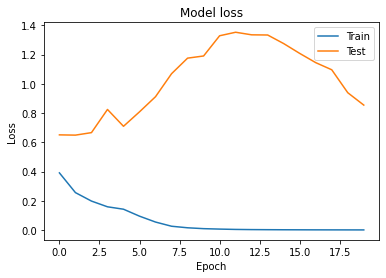

In [ ]:
history = model.fit(train_data, train_label,
                    validation_data=(val_data, val_label),
                    batch_size=64, epochs=20)

plot_loss()

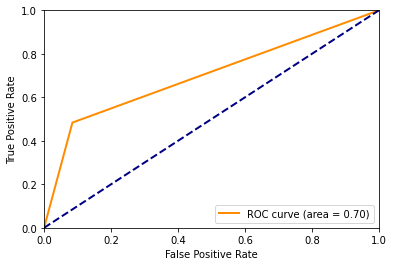

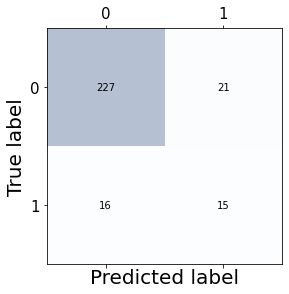

accuracy: 0.8674
precision: 0.4167
recall: 0.4839
f1 score: 0.4478


In [ ]:
predict_label = model.predict(val_data).round()
evaluate(val_label, predict_label)

### Training (bonus)

In [ ]:
def buildBonusModel():
  img_data = keras.layers.Input(shape=(64, 64, 1))
  num_data = keras.layers.Input(shape=(50))

  # image data extraction
  x = keras.layers.Conv2D(32, 6, strides=2, input_shape=(64, 64, 1), activation='relu')(img_data)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(32, 3, strides=2, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(32, 3, strides=1, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Flatten()(x)
  x = keras.Model(inputs=img_data, outputs=x)

  # numeric data extraction
  y = keras.layers.Dense(units=32, activation="relu")(num_data)
  y = keras.layers.BatchNormalization()(y)
  y = keras.layers.Dense(units=16, activation="relu")(y)
  y = keras.layers.BatchNormalization()(y)
  y = keras.layers.Dense(units=8, activation="relu")(y)
  y = keras.layers.BatchNormalization()(y)
  y = keras.Model(inputs=num_data, outputs=y)

  # fully connected layer
  combined = keras.layers.concatenate([x.output, y.output])
  z = keras.layers.Dense(units=128, activation="relu")(combined)
  z = keras.layers.Dense(units=1, activation="sigmoid")(z)

  return keras.Model(inputs=[x.input, y.input], outputs=z)

bonusModel = buildBonusModel()

loss = keras.losses.BinaryCrossentropy()
bonusModel.compile(optimizer='adam', loss=loss, metrics=['accuracy', Precision(), Recall()])
bonusModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 30, 30, 32)   1184        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 15, 15, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 50)]         0                                            
____________________________________________________________________________________________

Epoch 1/20
31/31 [==============================] - 4s 79ms/step - loss: 0.5364 - accuracy: 0.7339 - precision_2: 0.7469 - recall_2: 0.6922 - val_loss: 0.7678 - val_accuracy: 0.1326 - val_precision_2: 0.1107 - val_recall_2: 0.9677
Epoch 2/20
31/31 [==============================] - 2s 71ms/step - loss: 0.3293 - accuracy: 0.8628 - precision_2: 0.8768 - recall_2: 0.8443 - val_loss: 0.8194 - val_accuracy: 0.1183 - val_precision_2: 0.1091 - val_recall_2: 0.9677
Epoch 3/20
31/31 [==============================] - 2s 64ms/step - loss: 0.2264 - accuracy: 0.9087 - precision_2: 0.9273 - recall_2: 0.8857 - val_loss: 0.8463 - val_accuracy: 0.1613 - val_precision_2: 0.1170 - val_recall_2: 1.0000
Epoch 4/20
31/31 [==============================] - 2s 66ms/step - loss: 0.1810 - accuracy: 0.9342 - precision_2: 0.9451 - recall_2: 0.9219 - val_loss: 0.8823 - val_accuracy: 0.2186 - val_precision_2: 0.1245 - val_recall_2: 1.0000
Epoch 5/20
31/31 [==============================] - 2s 64ms/step - loss: 0.1

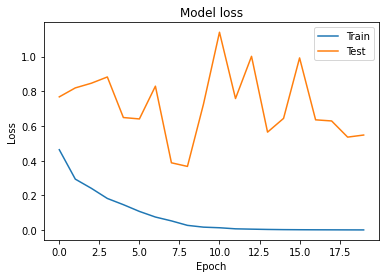

In [ ]:
history = bonusModel.fit(x=[train_data, train_num_data], y=train_label,
                         validation_data=([val_data, val_num_data], val_label),
                         batch_size=64, epochs=20)

plot_loss()

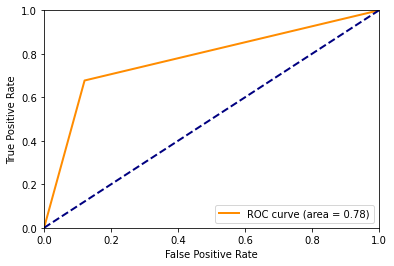

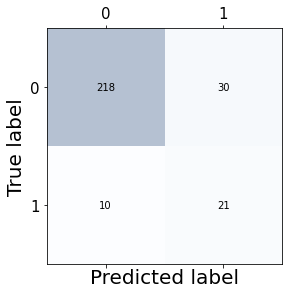

accuracy: 0.8566
precision: 0.4118
recall: 0.6774
f1 score: 0.5122


In [ ]:
predict_label = bonusModel.predict([val_data, val_num_data]).round()
evaluate(val_label, predict_label)

### Save Model

In [ ]:
model.save(dir + "output/106062314_HW3_Model.h5")

In [ ]:
bonusModel.save(dir + "output/Bonus_106062314_HW3_Model.h5")

### Load Model

In [ ]:
model = keras.models.load_model(dir + "output/106062314_HW3_Model.h5")

In [ ]:
bonusModel = keras.models.load_model(dir + "output/Bonus_106062314_HW3_Model.h5")

In [ ]:
test_patient_id = []
for filename in os.listdir(dir + "IML_CXR_TEST/"):
  test_patient_id.append(int(filename[:-4]))
test_patient_id.sort()

test_data = []
for id in tqdm(test_patient_id):
  filepath = dir + "IML_CXR_TEST/" + str(id) + ".jpg"
  img = image.load_img(filepath, grayscale=True, target_size=(64, 64))
  img = np.array(img)
  test_data.append(img)
test_data = np.array(test_data).reshape(-1, 64, 64, 1)

# normalization
test_data = test_data / 255.0

100%|██████████| 457/457 [00:01<00:00, 442.60it/s]


In [ ]:
def getNumericData(filepath, patient_id):
  df = pd.read_csv(filepath)

  # impute missing values
  df = df.fillna(df.mean())

  # encode class input to one-hot
  df['sex'] = df['sex'].map({'MALE': 0, 'FEMALE': 1})
  ed_diagnosis_list = ['sx_breathing_difficulty', 'sx_flu', 'sx_fever', 'sx_cough', 'sx_others']
  for element in ed_diagnosis_list:
    df[element] = df['ed_diagnosis'].map(lambda x: 1 if x == element else 0)

  num_patient_id = np.array(df['PATIENT ID']).tolist()

  # drop useless information
  df = df.drop(['PATIENT ID', 'admission_datetime', 'ed_diagnosis'], axis=1)

  # convert dataframe to numpy array
  num_data_raw = np.array(df)

  # extract data with patient_id
  num_data = []
  for id in patient_id:
    row = num_patient_id.index(id)
    num_data.append(num_data_raw[row])
  num_data = np.array(num_data)
  return num_data

test_num_data = getNumericData(filepath=dir+"fixed_test.csv", patient_id=test_patient_id)

print("image data   :", test_data.shape)
print("numeric data :", test_num_data.shape)

image data   : (457, 64, 64, 1)
numeric data : (457, 50)


In [ ]:
predict_label = model.predict(test_data).round()
predict_label = np.array(predict_label)

# save predictions
df = pd.DataFrame(predict_label)
df.columns = ['hospital_outcome']
df.index = test_patient_id
df.to_csv(dir + "output/106062314.csv")

In [ ]:
predict_label = bonusModel.predict([test_data, test_num_data]).round()
predict_label = np.array(predict_label)

# save predictions
df = pd.DataFrame(predict_label)
df.columns = ['hospital_outcome']
df.index = test_patient_id
df.to_csv(dir + "output/Bonus_106062314.csv")